In [1]:
import pygad.kerasga
import pygad
from pygad.kerasga import KerasGA
import numpy
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import tensorflow 
import time
from IPython.display import display, clear_output, HTML

In [2]:
# higher numbers mean more bad

PAYOFFS = {          # :}
    (0, 0): (1, 1),  # Both cooperate
    (0, 1): (10, 10),  # Player A cooperates, Player B defects
    (1, 0): (0, 0),  # Player A defects, Player B cooperates
    (1, 1): (5, 5)   # Both defect
}

fit_history = []

## Layout of the input
<div style="text-align:center">
    <img src="layout.png" alt="drawing" height="400"/>
</div>

In [3]:
MEMORY_SIZE = 5 # can remember last memory_size rounds
NUM_ROUNDS = 20
NUM_SOLUTION = 10 # number of people in the network

NUM_GENERATIONS = 25 # Number of generations.
NUM_PARENTS_MATING = 5 # Number of solutions to be selected as parents in the mating pool.

# memory array holds memory of all instances
g_memory_array = numpy.zeros(shape=(NUM_SOLUTION, MEMORY_SIZE)) - 1 
g_buffer_memory_array = numpy.zeros(shape=(NUM_SOLUTION, MEMORY_SIZE)) - 1 

In [4]:
model = tensorflow.keras.Sequential([
    tensorflow.keras.Input(shape=(g_memory_array.shape[0], g_memory_array.shape[1], 1)),
    #tensorflow.keras.layers.MaxPool2D(),
    tensorflow.keras.layers.Conv2D(filters=2, kernel_size=3, strides=2, activation='relu'),
    tensorflow.keras.layers.Flatten(),
    tensorflow.keras.layers.Dense(10, activation="relu"),
    tensorflow.keras.layers.Dense(10, activation="sigmoid"),
    tensorflow.keras.layers.Dense(1, activation="sigmoid")
])
model.summary()
keras_ga = KerasGA(model=model, num_solutions=NUM_SOLUTION)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 4, 2, 2)        │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 311 (1.21 KB)

 Trainable params: 311 (1.21 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
results_array = numpy.zeros((NUM_SOLUTION))
t_array = []
AMOUNT_DIGITS = len(str(abs(NUM_GENERATIONS * NUM_ROUNDS)))

def generate_loading_bar(progress, total=30):
    filled_length = int(total * progress)
    bar = '#' * filled_length + ' ' * (total - filled_length)
    return f"[{bar}] {progress * 100:.1f}%"

def do_graph(title):
    global AMOUNT_DIGITS

    colors = ['green', 'red']
    cmap = ListedColormap(colors)
    plt.figure(figsize=(10, 10))
    binary_mask = g_memory_array > 0.5
    plt.imshow(binary_mask, cmap=cmap, interpolation='nearest', vmin=0, vmax=1)
    #plt.axis('off') 
    plt.title(title)
    plt.xlabel("Memory")
    plt.ylabel("All Players")
    plt.savefig(f"./out/img_{do_graph.graph_index:0{AMOUNT_DIGITS}}.png", bbox_inches='tight')
    
    do_graph.graph_index += 1
    
    plt.close()

do_graph.graph_index = 0

display_handle = display(HTML("Starting..."), display_id=True)
def do_the_thing(ga_instance):    
    if do_the_thing.gen == ga_instance.generations_completed:
        return
    do_the_thing.gen += 1
    
    global g_memory_array, g_buffer_memory_array, model, results_array, t_array, display_handle
    
    results_array = numpy.zeros((NUM_SOLUTION)) 

    # reset the memory array
    g_memory_array = numpy.zeros(shape=(NUM_SOLUTION, MEMORY_SIZE)) - 1 
    # let the solutions fight until the death 
    for round_num in range(NUM_ROUNDS):
        t_start = time.time()
        for i, sol in enumerate(ga_instance.population):
            prediction = pygad.kerasga.predict(model, sol, g_memory_array.reshape(1, NUM_SOLUTION, MEMORY_SIZE, 1))
            g_buffer_memory_array[i] = numpy.append(g_memory_array[i], prediction)[1:] 
        # save the memory array for the next round    
        g_memory_array = g_buffer_memory_array
        # calculate the fitness
        for i, _ in enumerate(ga_instance.population):
            own_prediction = g_memory_array[i, -1]
            for j, _ in enumerate(ga_instance.population):
                opponent_prediction = g_memory_array[j, -1]
                results_array[i] -= PAYOFFS[(1 if own_prediction > 0.5 else 0, 1 if opponent_prediction > 0.5 else 0)][0] # this is always player 1

        do_graph(f"Generation {ga_instance.generations_completed} Round {round_num}")
        t_end = time.time()
        t_array.append(t_end - t_start)
        clear_output(wait=True)
        display_handle.update(HTML(f"""Currently at <b>Generation {ga_instance.generations_completed}</b> and <b>Round {round_num}</b><br>
                                       Avg time for rounds {numpy.mean(t_array):.2f} s<br>
                                       ETA for remaining {NUM_ROUNDS - round_num} rounds: {numpy.mean(t_array) * (NUM_ROUNDS - round_num):.2f} s<br>
                                       ETA for all gens: {numpy.mean(t_array) * (NUM_ROUNDS * NUM_GENERATIONS - NUM_ROUNDS * (ga_instance.generations_completed - 1) - round_num)/60:.2f} min<br>
                                       <pre><code>{generate_loading_bar((NUM_ROUNDS * (ga_instance.generations_completed) + round_num)/(NUM_ROUNDS * (NUM_GENERATIONS + 1)))}</code></pre>"""))

do_the_thing.gen = 0

def fitness_func(ga_instance, solution, sol_idx):
    if sol_idx == None: # the docs say that this is needed
        sol_idx = 1
        
    global gacnn_instance, g_memory_array, g_buffer_memory_array, results_array

    do_the_thing(ga_instance)

    return results_array[sol_idx]

def callback_generation(ga_instance):    
    global g_memory_array
    
    fit_history.append(numpy.mean(ga_instance.cal_pop_fitness()))
    g_memory_array = g_buffer_memory_array
    #do_graph(f"Avg fitness {fit_history[-1]}")
    #print(f"\\\\\\\\\\\\\\\\\\\\ Starting Generation {ga_instance.generations_completed} //////////")


In [6]:
ga_instance = pygad.GA(num_generations=NUM_GENERATIONS,
                       num_parents_mating=NUM_PARENTS_MATING,
                       initial_population=keras_ga.population_weights,
                       mutation_type="adaptive",
                       mutation_probability=[0.2, 0.01],
                       suppress_warnings=True,
                       fitness_func=fitness_func,
                       on_generation=callback_generation)

ga_instance.run()

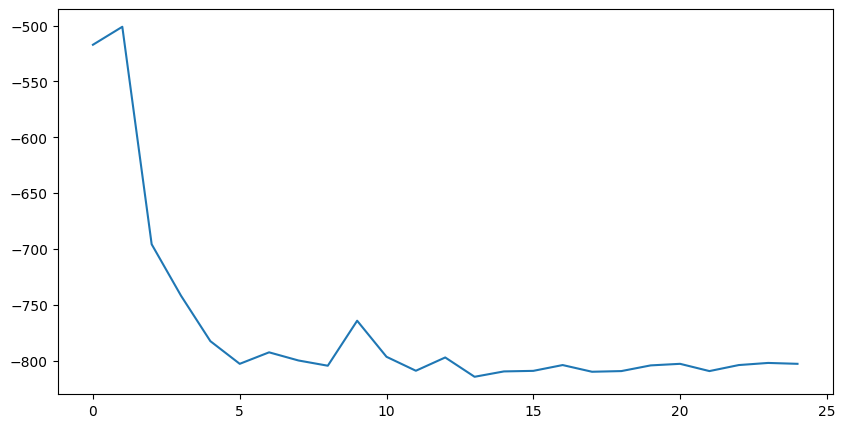

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(fit_history)), fit_history)
plt.savefig(f"./out/fitness.png", bbox_inches='tight')